In [12]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
print("done")

done


In [ ]:
DATA_ROOT = "../../fiot_highway2-main/data/"
BOOSTED_CLASS1_ROOT = "./BoostedClass1"
BOOSTED_CLASS3_ROOT = "./BoostedClass3"
TRAIN_TXT = "../../fiot_highway2-main/train.txt"
TEST_TXT  = "../../fiot_highway2-main/test.txt"
MIN_LABEL = 0
MAX_LABEL = 8
RESIZE_TO = (64, 64)
BATCH_SIZE = 32
LR = 1e-3
MAX_EPOCHS = 10
MIN_DB = -140.0 #WARNING: based on visualzing dataset may not be the absolute min
MAX_DB =   0.0

def struct_extract(struct, min_label, max_label):
    paths  = []
    labels = []
    for entry in struct:
        label = int(entry[1])
        if min_label <= label <= max_label:
            path = entry[0].split('/')[1].split('.')[0]
            paths.append(path)
            labels.append(label)
    return paths, labels

all_train_struct = np.loadtxt(TRAIN_TXT, dtype=str).tolist()
all_test_struct  = np.loadtxt(TEST_TXT,  dtype=str).tolist()

def boosted_struct_extract(boosted_folder, target_label=3):
    files = [f for f in os.listdir(boosted_folder) if f.endswith('.npy')]
    paths = [os.path.splitext(f)[0] for f in files]
    labels = [target_label] * len(paths)
    return paths, labels

train_paths, train_labels = struct_extract(all_train_struct, MIN_LABEL, MAX_LABEL)
test_paths,  test_labels  = struct_extract(all_test_struct,  MIN_LABEL, MAX_LABEL)
boosted1_paths, boosted1_labels = boosted_struct_extract(BOOSTED_CLASS1_ROOT, target_label=1)
boosted3_paths, boosted3_labels = boosted_struct_extract(BOOSTED_CLASS3_ROOT, target_label=3)
print(len(train_labels))
print(len(boosted3_paths))
print("done")

class HighwayDataset(Dataset):
    def __init__(self, paths, labels, data_root, resize=(64,64)):
        self.paths = paths
        self.labels = labels
        self.data_root = data_root
        self.resize = resize

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        fname = self.paths[idx] + ".npy"
        arr = np.load(os.path.join(self.data_root, fname))   # shape (512,243)
        arr = np.clip(arr, MIN_DB, MAX_DB) # Clip to a fixed dB range 
        arr = (arr - MIN_DB) / (MAX_DB - MIN_DB) # Scale to [0,1] VERIFY THIS
        img = torch.from_numpy(arr.astype(np.float32))    # H x W
        img = img.unsqueeze(0)                            # 1 Input Channel (amplitude) || 1 x H x W
        img = TF.resize(img, self.resize)                 # RESIZE still 1 x h x w
        label = int(self.labels[idx]) - MIN_LABEL # **** Label shift 
        return img, label

train_ds = HighwayDataset(train_paths, train_labels, DATA_ROOT, RESIZE_TO)
test_ds  = HighwayDataset(test_paths,  test_labels, DATA_ROOT, RESIZE_TO)
boosted_class3_train_ds = HighwayDataset(boosted3_paths, boosted3_labels, BOOSTED_CLASS3_ROOT, RESIZE_TO)
boosted_class1_train_ds = HighwayDataset(boosted1_paths, boosted1_labels, BOOSTED_CLASS1_ROOT, RESIZE_TO)

# merged_train_ds = ConcatDataset([train_ds])
# #merged_train_ds = ConcatDataset([train_ds, boosted_class3_train_ds])
# merged_train_ds = ConcatDataset([train_ds])

# train_loader = DataLoader(merged_train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4) #best number workers depends on CPU cores
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, num_workers=4) #best number workers depends on CPU cores
print("done")

12915
500
done
done


In [3]:
class CNN(pl.LightningModule):
    def __init__(self, num_classes=MAX_LABEL-MIN_LABEL+1, depth="shallow"):
        super().__init__()
        self.save_hyperparameters()

        if depth == "shallow":
            self.model = nn.Sequential(
                nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
                nn.MaxPool2d(2),                      # 64 → 32
                nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
                nn.MaxPool2d(2),                      # 32 → 16
                nn.Flatten(),
                nn.Linear(32 * 16 * 16, 128), nn.ReLU(),
                nn.Linear(128, num_classes)
            )

        elif depth == "deep":
            self.model = nn.Sequential(
                nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
                nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
                nn.MaxPool2d(2),                      # 64 → 32
                nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                nn.MaxPool2d(2),                      # 32 → 16
                nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
                nn.Flatten(),
                nn.Linear(128 * 16 * 16, 128), nn.ReLU(),
                nn.Linear(128, num_classes)
            )

        else:
            raise ValueError("depth must be 'shallow' or 'deep'")

        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(1) == y).float().mean()
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(1) == y).float().mean()
        self.log("test_loss", loss)
        self.log("test_acc", acc)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=LR)

In [19]:
def plot_logs(exp_name):
    csv_path = os.path.join("logs", exp_name, "version_0", "metrics.csv")
    df = pd.read_csv(csv_path)

    train_acc = df[df["train_acc"].notna()]
    train_loss = df[df["train_loss"].notna()]

    plt.figure(figsize=(10, 4))

    # Train Loss
    plt.subplot(1, 2, 2)
    plt.plot(train_loss["step"], train_loss["train_loss"], label="Train Loss")
    plt.title(f"{exp_name} — Train Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.legend()

    # Train Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(train_acc["step"], train_acc["train_acc"], label="Train Accuracy")
    plt.title(f"{exp_name} — Train Accuracy")
    plt.xlabel("Step")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [4]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(model, dataloader, title):
    y_true, y_pred = [], []

    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            logits = model(x)
            preds = logits.argmax(1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=list(range(MIN_LABEL, MAX_LABEL + 1)),
        yticklabels=list(range(MIN_LABEL, MAX_LABEL + 1)),
    )

    plt.gca().xaxis.set_label_position("top")
    plt.gca().xaxis.tick_top()
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title, pad=20)
    plt.show()

In [5]:
experiments = [
    {"name": "shallow_no_aug", "depth": "shallow", "augment": False},
    {"name": "shallow_aug",    "depth": "shallow", "augment": True},
    {"name": "deep_no_aug",    "depth": "deep",    "augment": False},
    {"name": "deep_aug",       "depth": "deep",    "augment": True},
]

/usr/local/lib/python3.12/site-packages/torch/cuda/__init__.py:827: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



=== Running shallow_no_aug ===


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 1.1 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.219     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7594053149223328     │
│         test_loss         │    0.6349184513092041     │
└───────────────────────────┴───────────────────────────┘

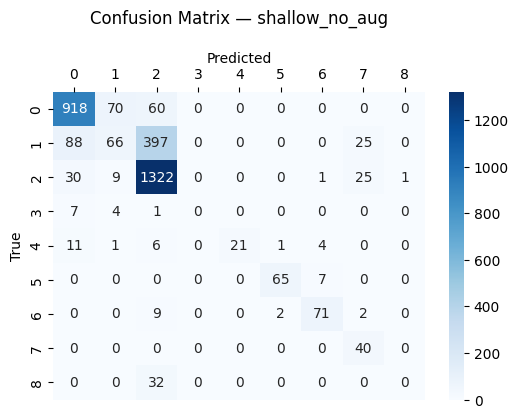

/usr/local/lib/python3.12/site-packages/torch/cuda/__init__.py:827: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 1.1 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.219     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode



=== Running shallow_aug ===


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7885315418243408     │
│         test_loss         │    0.5475725531578064     │
└───────────────────────────┴───────────────────────────┘

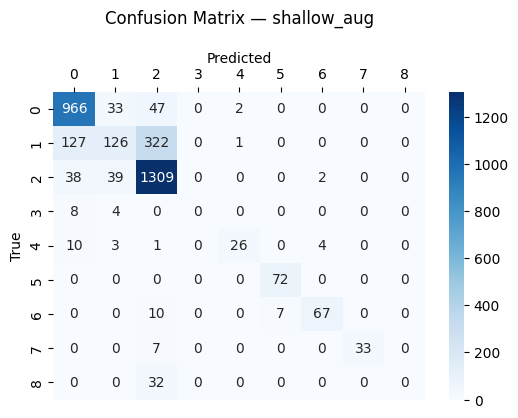

/usr/local/lib/python3.12/site-packages/torch/cuda/__init__.py:827: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 4.3 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
4.3 M     Trainable params
0         Non-trainable params
4.3 M     Total params
17.171    Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode



=== Running deep_no_aug ===


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7894417643547058     │
│         test_loss         │    0.5473909378051758     │
└───────────────────────────┴───────────────────────────┘

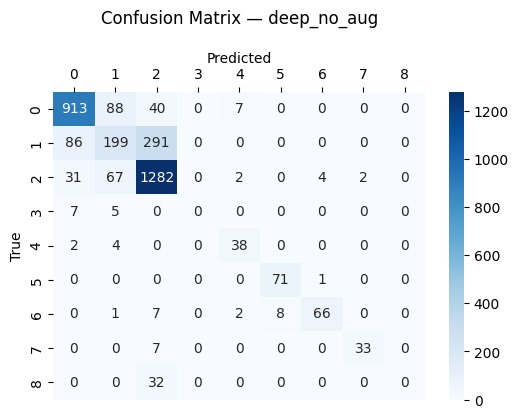

/usr/local/lib/python3.12/site-packages/torch/cuda/__init__.py:827: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 4.3 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
4.3 M     Trainable params
0         Non-trainable params
4.3 M     Total params
17.171    Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode



=== Running deep_aug ===


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7939926981925964     │
│         test_loss         │    0.5343485474586487     │
└───────────────────────────┴───────────────────────────┘

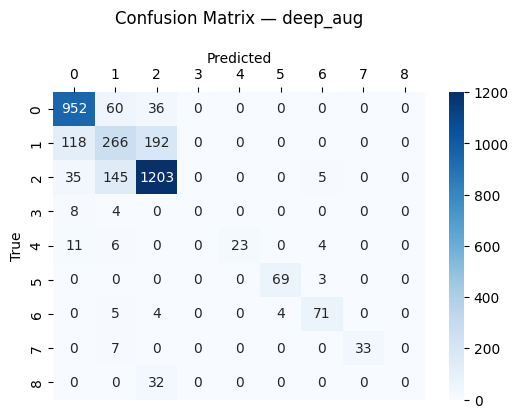

In [6]:
for exp in experiments:
    print(f"\n=== Running {exp['name']} ===")

    if exp["augment"]:
        merged_train_ds = ConcatDataset([
            train_ds,
            boosted_class3_train_ds,
            boosted_class1_train_ds
        ])
    else:
        merged_train_ds = ConcatDataset([train_ds])

    train_loader = DataLoader(
        merged_train_ds,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=4
    )

    model = CNN(depth=exp["depth"])

    logger = CSVLogger(
        "logs",
        name=f"cnn_highway_{exp['name']}"
    )

    trainer = pl.Trainer(
        max_epochs=MAX_EPOCHS,
        logger=logger,
        accelerator="auto"
    )

    trainer.fit(model, train_loader)
    trainer.test(model, test_loader)
    
    plot_confusion_matrix(
    model,
    test_loader,
    title=f"Confusion Matrix — {exp['name']}"
)

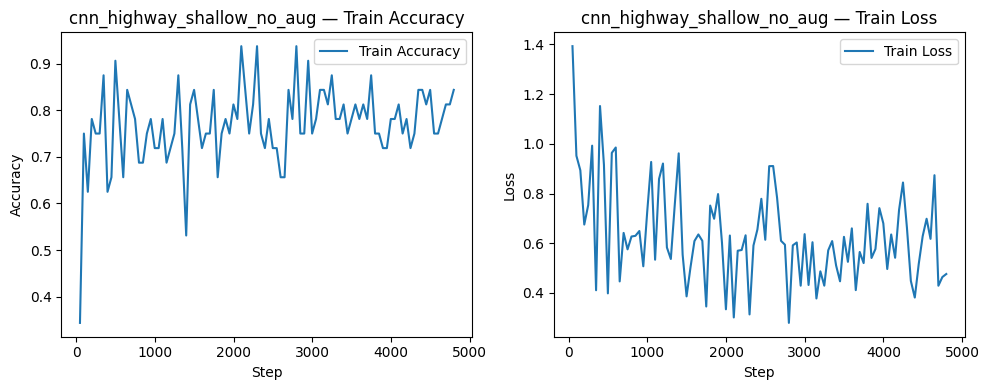

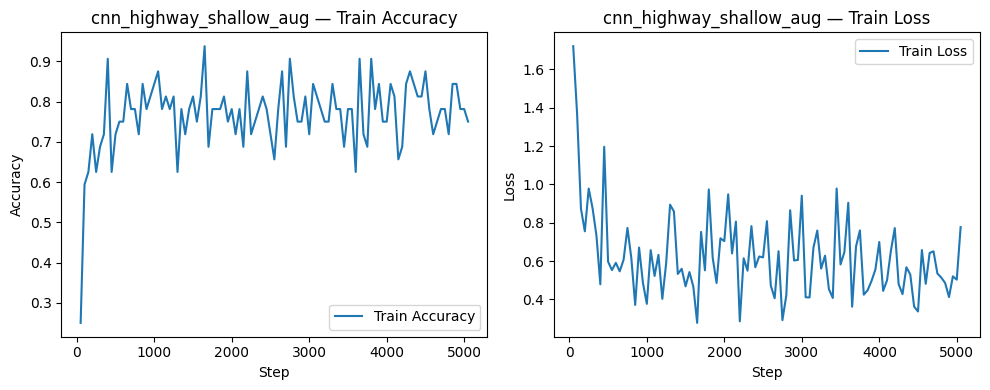

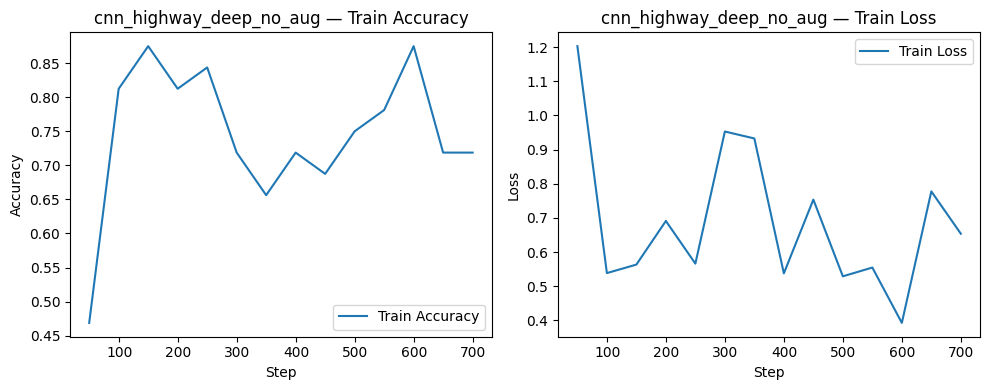

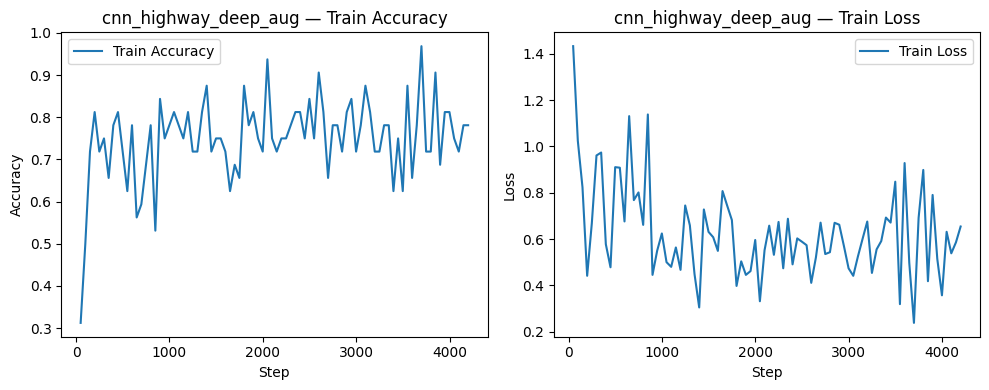

In [18]:
for exp in experiments:
    plot_logs("cnn_highway_" + exp["name"])